# <font color=black size=6>DonorsChoose Project Approval Prediction</font> 

<font color=black size=4>@CicilyWu</font> 

![Image of Yaktocat](https://www.hyperakt.com/assets/DC_tote.jpg)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DonorsChoose-Project-Approval-Prediction" data-toc-modified-id="DonorsChoose-Project-Approval-Prediction-1"><font color="black" size="6">DonorsChoose Project Approval Prediction</font></a></span></li><li><span><a href="#1.-Problem-Statement" data-toc-modified-id="1.-Problem-Statement-2">1. Problem Statement</a></span></li><li><span><a href="#2.-Data-Description" data-toc-modified-id="2.-Data-Description-3">2. Data Description</a></span></li><li><span><a href="#3.-Data-Cleaning,-Analysis-and-Visualization" data-toc-modified-id="3.-Data-Cleaning,-Analysis-and-Visualization-4">3. Data Cleaning, Analysis and Visualization</a></span></li><li><span><a href="#4.-NLP:-TF-IDF-Model-and-Visualization" data-toc-modified-id="4.-NLP:-TF-IDF-Model-and-Visualization-5">4. NLP: TF-IDF Model and Visualization</a></span></li><li><span><a href="#5.-Xgboost-Model-for-Prediction" data-toc-modified-id="5.-Xgboost-Model-for-Prediction-6">5. Xgboost Model for Prediction</a></span></li></ul></div>

# 1. Problem Statement

<font color=black size=3>Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.  

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.  

 DonorsChoose.org expects to receive close to 500,000 project proposals a year starting next year. As a result, there are three main problems they need to solve:  

1. How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible?  

2. How to increase the consistency of project vetting across different volunteers to improve the experience for teachers? 

3. How to focus volunteer time on the applications that need the most assistance?

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.  

With an algorithm to pre-screen applications, DonorsChoose.org can auto-approve some applications quickly so that volunteers can spend their time on more nuanced and detailed project ​vetting processes, including doing more to help teachers develop projects that qualify for specific funding opportunities.  

The machine learning algorithm can help more teachers get funded more quickly, and with less cost to DonorsChoose.org, allowing them to channel even more funding directly to classrooms across the country.</font>   

# 2. Data Description

<font color=black size=3>**File descriptions:**  
train.csv - the training set  
test.csv - the test set  
resources.csv - resources requested by each proposal; joins with test.csv and train.csv on id  
sample_submission.csv - a sample submission file in the correct format  

**Data fields:**  
test.csv and train.csv:  
id - unique id of the project application  
teacher_id - id of the teacher submitting the application  
teacher_prefix - title of the teacher's name (Ms., Mr., etc.)  
school_state - US state of the teacher's school  
project_submitted_datetime - application submission timestamp  
project_grade_category - school grade levels (PreK-2, 3-5, 6-8, and 9-12)  
project_subject_categories - category of the project (e.g., "Music & The Arts")  
project_subject_subcategories - sub-category of the project (e.g., "Visual Arts")  
project_title - title of the project  
project_essay_1 - first essay*  
project_essay_2 - second essay*  
project_essay_3 - third essay*  
project_essay_4 - fourth essay*  
project_resource_summary - summary of the resources needed for the project  
teacher_number_of_previously_posted_projects - number of previously posted applications by the submitting teacher  
project_is_approved - whether DonorsChoose proposal was accepted (0="rejected", 1="accepted"); train.csv only  
*Note: Prior to May 17, 2016, the prompts for the essays were as follows:*  

project_essay_1: "Introduce us to your classroom"  
project_essay_2: "Tell us more about your students"  
project_essay_3: "Describe how your students will use the materials you're requesting"  
project_essay_4: "Close by sharing why your project will make a difference"  
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:  

project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."  
project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"  
For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.  

resources.csv:  

Proposals also include resources requested. Each project may include multiple requested resources. Each row in resources.csv corresponds to a resource, so multiple rows may tie to the same project by id.  

id - unique id of the project application; joins with test.csv. and train.csv on id  
description - description of the resource requested  
quantity - quantity of resource requested  
price - price of resource requested</font>   

# 3. Data Cleaning, Analysis and Visualization

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [14]:
train = pd.read_csv('D:/DonorsCompetition/train.csv')
train=train.drop(['teacher_id'], axis=1)
train.columns=['id','teacher_prefix','state','submit_date','grade','subject',
               'subject_sub','title','essay1','essay2','essay3','essay4','summary','previous_posted','approved']

How many features is bad/missing value? : 3


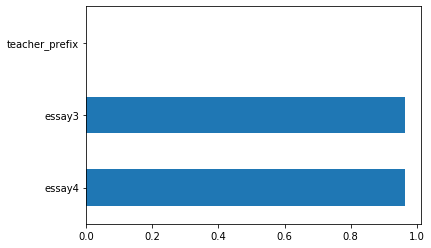

In [15]:
cols_missing_value = train.isnull().sum()/train.shape[0]
cols_missing_value = cols_missing_value[cols_missing_value>0]
print("How many features is bad/missing value? :",cols_missing_value.shape[0])
cols_missing_value.sort_values(ascending=False).head(10).plot.barh()

<font color=purple size=4>From here we can see this dataset is very organized and clean almost without any null values. As the desciption said before, they cancelled "essay3" and "essay4" after May 2016 which is the reason why they have blanks. We will process data to combine them with "essay1" and "essay2" later.</font>

In [16]:
train=train.drop_duplicates()
train.shape

(182080, 15)

In [17]:
resources= pd.read_csv('D:/DonorsCompetition/resources.csv')
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [18]:
resources.shape

(1541272, 4)

In [19]:
resources['cost']=resources['quantity']*resources['price']
resources.head()

,id,description,quantity,price,cost
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,44.85
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59,27.18
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95,74.85


In [20]:
resources_aggregated = resources.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['mean', 'sum']})
resources_aggregated.columns = ['item_count', 'total_quantity', 'mean_cost', 'total_cost']
resources_aggregated.reset_index(inplace=True)
resources_aggregated.head()

,id,item_count,total_quantity,mean_cost,total_cost
0,p000001,4,7,208.407500,833.63
1,p000002,14,21,45.020000,630.28
2,p000003,4,4,74.742500,298.97
3,p000004,93,98,11.854947,1126.22
4,p000005,2,8,175.577500,702.31


In [21]:
df = pd.merge(train, resources_aggregated, how='left', on='id')
df.head(2)

,id,teacher_prefix,state,submit_date,grade,subject,subject_sub,title,essay1,essay2,essay3,essay4,summary,previous_posted,approved,item_count,total_quantity,mean_cost,total_cost
0,p036502,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,2,6,449.97,899.94
1,p039565,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,1,20,400.00,400.00


<font color=purple size=4>I will conduct a visualization to check the distribution of approved/rejected cases in each domain. We did not see a huge difference in "teacher_prefix" and "grade". </font>

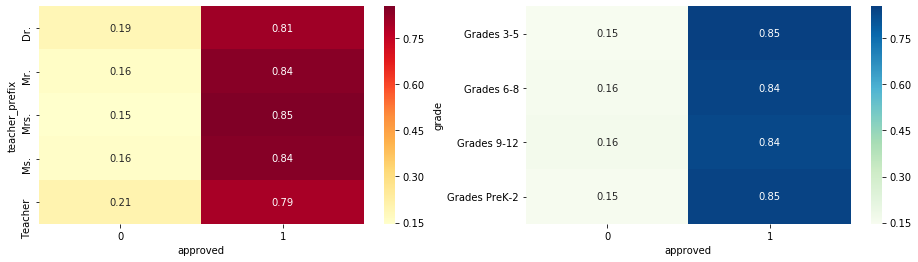

In [12]:
# More about crosstab: https://zhuanlan.zhihu.com/p/52368125
fig = plt.figure(figsize=(16,4),facecolor = 'white')

ax1 = fig.add_subplot(1,2,1)
prefix=pd.crosstab(df.teacher_prefix, df.approved, dropna=False, normalize='index')
ax1=sns.heatmap(prefix, cmap='YlOrRd', annot=True)

ax3 = fig.add_subplot(1,2,2)
grade=pd.crosstab(df.grade, df.approved, dropna=False, normalize='index')
ax3=sns.heatmap(grade, cmap='GnBu', annot=True)

<font color=purple size=4> There is no significant difference in "state" domain either.</font>

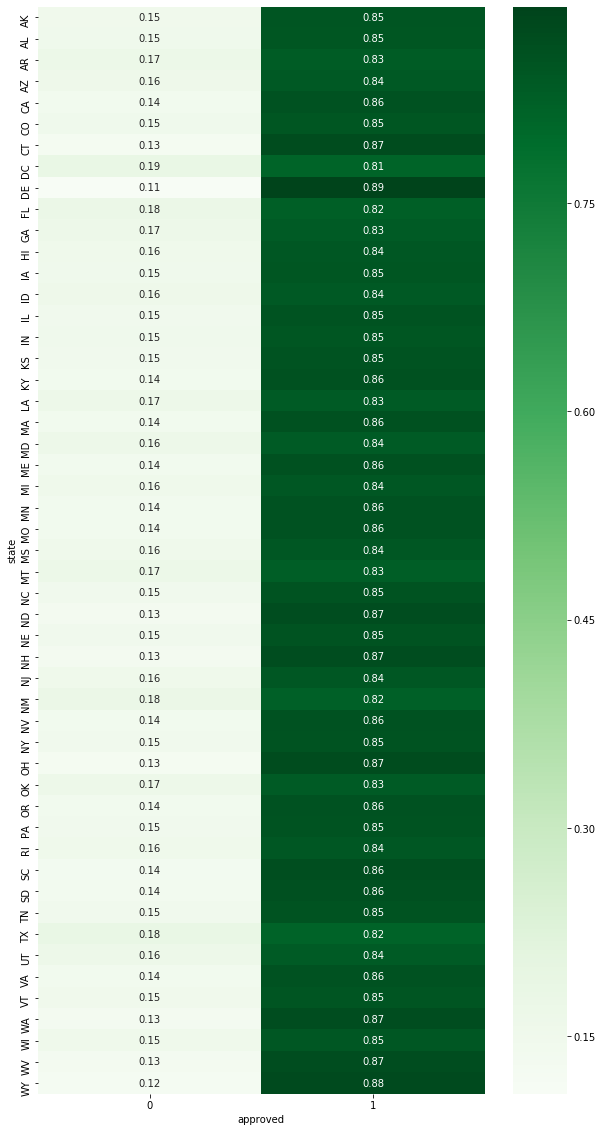

In [23]:
fig = plt.figure(figsize=(10,20),facecolor = 'white')
state=pd.crosstab(df.state, df.approved, dropna=False, normalize='index')
sns.heatmap(state, cmap='Greens', annot=True)

In [24]:
state1=state.copy()
state1['approved_count']=df.groupby('state').approved.sum()

In [25]:
state1=state1.reset_index()
state1.columns=['state','reject','approve','approved']

In [26]:
state1.head()

,state,reject,approve,approved
0,AK,0.150808,0.849192,473
1,AL,0.151607,0.848393,2507
2,AR,0.167900,0.832100,1462
3,AZ,0.158273,0.841727,3042
4,CA,0.143569,0.856431,22006


In [27]:

import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#state_approved = f'{url}/US_Unemployment_Oct2012.csv'
state_data = state1

m = folium.Map(location=[35, -95], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['state', 'approved'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Approved Projects Count'
).add_to(m)

folium.LayerControl().add_to(m)

m

<font color=purple size=4>Above is the count of approved cases in each state.We can see that California has the most approved cases. </font>

In [28]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#state_approved = f'{url}/US_Unemployment_Oct2012.csv'
state_data = state1

m = folium.Map(location=[35, -95], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['state', 'approve'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Approved Rate'
).add_to(m)

folium.LayerControl().add_to(m)

m

<font color=purple size=4>Above is the approved rate in each state.We can see that California has the most approved cases.We can see that Washington, Delware,Wyoming and North Dakota has the highest approval rate.</font>

In [29]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#state_approved = f'{url}/US_Unemployment_Oct2012.csv'
state_data = state1

m = folium.Map(location=[35, -95], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['state', 'reject'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Rejected Rate'
).add_to(m)

folium.LayerControl().add_to(m)

m

<font color=purple size=4>It's also interesting to see the rejected rate. We can see Texas, New Mexico and Florida has the highest rejection rate.</font>

In [39]:
from scipy import stats

In [40]:
def plotmoney(x):
        df[x] = stats.boxcox(df[x] + 1)[0]
        plt.hist(df[x],color="powderblue");
        plt.title('Boxcox Transformed for '+x)

<font color=purple size=4>I normalized data to show the distribution.</font>

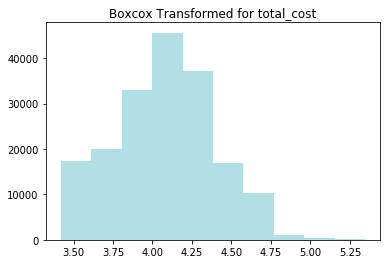

In [41]:
plotmoney('total_cost')

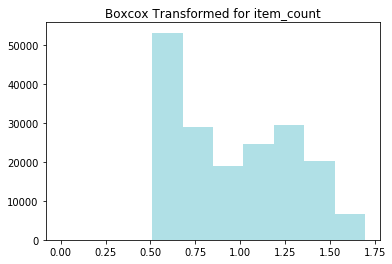

In [42]:
plotmoney('item_count')

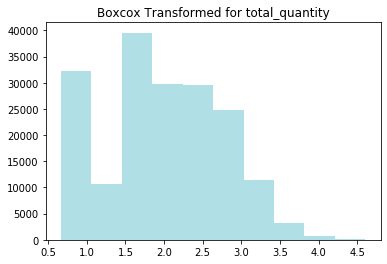

In [43]:
plotmoney('total_quantity')

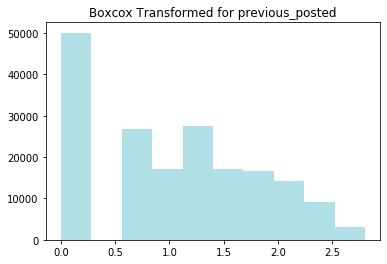

In [44]:
plotmoney('previous_posted')

Text(0, 0.5, 'How many cases got approved')

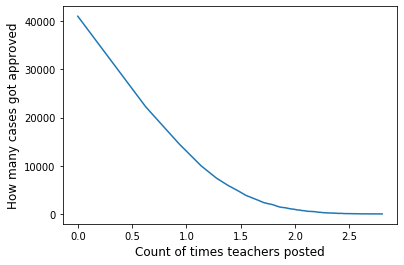

In [45]:
previous_posted=df.groupby('previous_posted').approved.sum()
ax1=sns.lineplot(data=previous_posted)
plt.xlabel('Count of times teachers posted',fontsize=12)
plt.ylabel('How many cases got approved',fontsize=12)

<font color=purple size=4>From above chart we can see that if a teacher has never posted a project before, the project has the higher chance to be approved.</font>

In [46]:
import plotly as py

<font color=purple size=4>I will use target encode for "state" domain.I used to use dummy encoding for variables with 3 to 5 different values. But in fact, when the values is more than 3 especially more than 50 in this case, it's smarter to chose target encodings, in which case we can decrease the features numbers.</font>

In [30]:
def target_encode(trn_series=None, 
                  #tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    
    https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    #assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    #ft_trn_series.index = trn_series.index 
    #ft_tst_series = pd.merge(
    #    tst_series.to_frame(tst_series.name),
    #    averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
    #   on=tst_series.name,
    #    how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    #ft_tst_series.index = tst_series.index
    return ft_trn_series#, ft_tst_series

In [31]:
df['school_state']=target_encode(trn_series=df['state'], 
                  #tst_series=None, 
                  target=df['approved'])
df['school_state'].head(10)

0    0.856770
1    0.834087
2    0.835110
3    0.853480
4    0.856431
5    0.891341
6    0.857547
7    0.864923
8    0.847937
9    0.853792
Name: school_state, dtype: float64

In [49]:
df.head()

,id,teacher_prefix,state,submit_date,grade,subject,subject_sub,title,essay1,essay2,essay3,essay4,summary,previous_posted,approved,item_count,total_quantity,mean_cost,total_cost,school_state
0,p036502,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,2.093862,1,0.828450,1.728314,449.970,4.423431,0.856770
1,p039565,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,0.625874,0,0.578110,2.534414,400.000,4.086676,0.834087
2,p233823,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,1.386291,1,0.578110,0.664107,469.990,4.156612,0.835110
3,p185307,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,1.909101,0,1.147701,1.606135,136.894,4.313874,0.853480
4,p013780,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,2.255585,1,0.578110,1.026853,711.000,4.329341,0.856431


In [87]:
import datetime

In [88]:
df['submit_date']=pd.to_datetime(df['submit_date'])
df['submit_date']=df['submit_date'].dt.date
df['submit_date'].head()

0    2016-11-18
1    2017-04-26
2    2017-01-01
3    2016-08-12
4    2016-08-06
Name: submit_date, dtype: object

In [89]:
df['submit_date']=pd.to_datetime(df['submit_date'],format='%Y-%m-%d')
#df['submit_date']=df['submit_date'].dt.date

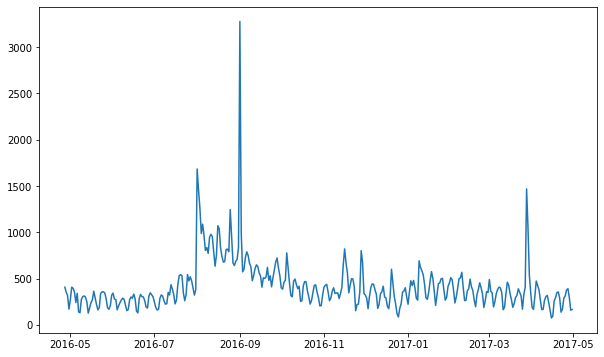

In [53]:
dates=df.groupby('submit_date').approved.sum()
fig = plt.figure(figsize=(10,6),facecolor = 'white')
ax1=sns.lineplot(data=dates)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right",fontsize=10)

<font color=purple size=4>Above chart shows the number of cases submitted during the year.</font>

In [95]:
print('Before 2016-05-17:', np.sum(df.submit_date < datetime.date(2016, 5, 7)))
print('After 2016-05-17:', np.sum(df.submit_date >= datetime.date(2016, 5, 7)))

Before 2016-05-17: 3751
After 2016-05-17: 178329


<font color=purple size=4>As mentioned before, we need to combine essays with the submission date before 2016-5-17</font>

In [98]:
df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay1'] = df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay1'] + ' ' + df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay2']
df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay2'] =df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay3'] + ' ' +df.loc[df.submit_date.dt.date < datetime.date(2016, 5, 7), 'essay4']
df.drop(['essay3', 'essay4'], axis=1, inplace=True)

# 4. NLP: TF-IDF Model and Visualization

In [5]:
from PIL import *
import PIL.Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import nltk
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 200)
import spacy
import gensim
from gensim import corpora
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
import inflect
import itertools
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\吴晓彤\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\吴晓彤\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\吴晓彤\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\吴晓彤\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [101]:
def apply_str(name):
    df[name]=df[name].apply(str)

In [103]:
apply_str('subject')
apply_str('subject_sub')
apply_str('title')
apply_str('essay1')
apply_str('essay2')
apply_str('summary')

In [104]:
# words to be removed from vocabulary
blockwords = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at','since','paid','don','doesn','close',
 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'doing', "don't", 'down', 'during',
 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's",
 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself',
 "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours' 'ourselves', 'out', 'over', 'own',
 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'like',
 'than', 'that',"that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", 'also','can','could','should',
 "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'not','bit','much',
 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where','within','quite','really','just','together',
 "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's",'will', 'with', "won't", 'would', "wouldn't", 'hole','furniture','put',
 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', "s'yourself'", 'yourselves', 'drawer','sure',
 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'hundred', 'thousand', '1st', '2nd', '3rd','nightstand','nightstands','night',
 '4th', '5th', '6th', '7th', '8th', '9th', '10th']

In [8]:
stop_words = set(stopwords.words('english'))                      # set of all stop words
lem=WordNetLemmatizer()
p=inflect.engine()

def process(comment):
  sent = comment.lower()                                          # lower case all words 
  words = nltk.word_tokenize(sent)
  words =  [word for word in words if not word in blockwords]     # remove words present in blockwords
  words = [word for word in words if not word.isdigit()]          # remove digit characters
  words = [word for word in words if len(word) > 3]               # remove words with length less than 3
  words = [word for word in words if word.isalpha()]              # remove non alphabetic words
  words = [lem.lemmatize(word) for word in words]                 # lemmatize words to root word
  sent = ' '.join(words)
  sent = re.sub(r'\(', '', sent)
  sent = re.sub(r'\)', '', sent)
  sent = re.sub(r"'", '', sent)
  return sent

def num_words(sent):                                              # returns number of words in the sentence
  word_tok=nltk.word_tokenize(sent)
  return len(word_tok)                                                                             

In [106]:
df['Cleaned_subject']=df['subject'].apply(process)
df['Unclean_len_subject']=df['subject'].apply(num_words)                     # word length of uncleaned comments
df['Clean_len_subject']=df.Cleaned_subject.apply(num_words)  

In [108]:
df['Cleaned_subject_sub']=df['subject_sub'].apply(process)                 # word length of uncleaned comments
df['Clean_len_subject_sub']=df.Cleaned_subject_sub.apply(num_words)  

In [110]:
df['Cleaned_title']=df['title'].apply(process)
df['Unclean_len_title']=df['title'].apply(num_words)                     # word length of uncleaned comments 

In [111]:
df['Cleaned_essay1']=df['essay1'].apply(process)
df['Unclean_len_essay1']=df['essay1'].apply(num_words)  

In [112]:
df['Cleaned_essay2']=df['essay2'].apply(process)
df['Unclean_len_essay2']=df['essay2'].apply(num_words)  

In [113]:
df['Cleaned_summary']=df['summary'].apply(process)
df['Unclean_len_summary']=df['summary'].apply(num_words)  

In [118]:
df.to_csv("D:\df_after.csv",index=False)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-118-716fec59e096>:1: DeprecationWarning: invalid escape sequence \d
  df.to_csv("D:\df_after.csv",index=False)


In [119]:
df_after = pd.read_csv('D:\df_after.csv')

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-119-92967b41b3fd>:1: DeprecationWarning: invalid escape sequence \d
  df_after = pd.read_csv('D:\df_after.csv')


In [121]:
pd.set_option('display.max_columns', None)

In [123]:
df_After=df_after.drop(['submit_date','grade','subject','subject_sub','title','essay1','essay2','summary','Clean_len_subject','Clean_len_subject_sub'], axis=1)

In [126]:
df_After['essay_length']=df_After['Unclean_len_essay1']+df_After['Unclean_len_essay2']

In [128]:
df_After.to_csv("D:\df_After.csv",index=False)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-128-54454eedd294>:1: DeprecationWarning: invalid escape sequence \d
  df_After.to_csv("D:\df_After.csv",index=False)


In [6]:
df_After = pd.read_csv('D:\df_After.csv')

invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d


In [9]:
vectorizer=TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(df_After['Cleaned_subject'])
df_After_subject = vectorizer.fit_transform(df_After['Cleaned_subject'])

In [10]:
df_After['Cleaned_subject_sub']=df_After['Cleaned_subject_sub'].values.astype('U')
vectorizer.fit(df_After['Cleaned_subject_sub'])
df_After_subject_sub = vectorizer.fit_transform(df_After['Cleaned_subject_sub'])

In [11]:
print('The number of features in subject:',df_After_subject.shape[1])
print('The number of features in subject_sub:',df_After_subject_sub.shape[1])

The number of features in subject: 17
The number of features in subject_sub: 45


In [12]:
df_After['Cleaned_essay1']=df_After['Cleaned_essay1'].values.astype('U')
df_After['Cleaned_essay2']=df_After['Cleaned_essay2'].values.astype('U')
df_After['Cleaned_summary']=df_After['Cleaned_summary'].values.astype('U')

In [13]:
num_features=200
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, max_features=num_features, stop_words='english')
df_After_essay1=tfidf.fit_transform(df_After['Cleaned_essay1'])
print('The number of features in essay1:',df_After_essay1.shape[1])

The number of features in essay1: 200


<font color=purple size=4>I chose 200 features here since the scope of the words in project is limited. This corpus is all about to help students get the stuff they needed in study so there is needless to set a large feature numbers. I believe a TF-IDF model with 200 features will definately show something for us. </font>

In [14]:
#show the sparse matrix
tf_vect_df = pd.DataFrame(df_After_essay1.todense(), columns=tfidf.get_feature_names())
tf_vect_df.head()

,ability,able,academic,access,achieve,active,activity,amazing,area,art,...,want,way,wide,wonderful,work,working,world,writing,year,young
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.107766,0.0,0.0,0.0,0.332443,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.454595,0.000000,0.0,0.0,0.0,0.095719,0.0
3,0.0,0.0,0.0,0.0,0.0,0.323204,0.560623,0.0,0.0,0.0,...,0.212489,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.359206,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [15]:
num_features=200
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, max_features=num_features, stop_words='english')
df_After_essay2=tfidf.fit_transform(df_After['Cleaned_essay2'])
print('The number of features in essay2:',df_After_essay2.shape[1])

The number of features in essay2: 200


In [16]:
num_features=200
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, max_features=num_features, stop_words='english')
df_After_summary=tfidf.fit_transform(df_After['Cleaned_summary'])
print('The number of features in summary:',df_After_summary.shape[1])

The number of features in summary: 200


In [17]:
def Convert(tup): # convert list of tuple to dictionary
    di = dict(tup) 
    return di

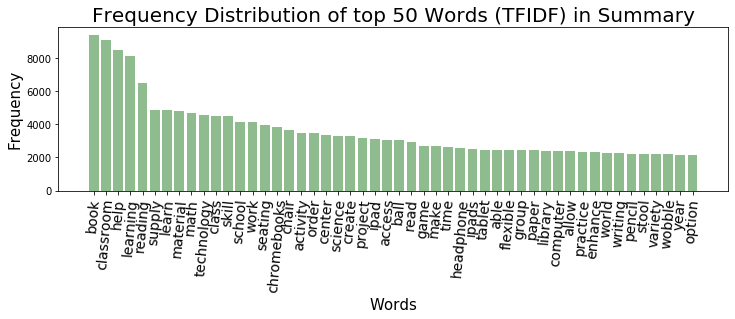

In [193]:
sum_words_tf = df_After_summary.sum(axis=0)
words_freq_tf = [(word, sum_words_tf[0, idx]) for word, idx in tfidf.vocabulary_.items()]
words_freq_tf =sorted(words_freq_tf, key = lambda x: x[1], reverse=True) # list of tuples in order

words_frequency_tf=Convert(words_freq_tf)
top_50_tf=dict(Counter(words_frequency_tf).most_common(50))

plt.figure(figsize=(12,3))
plt.title('Frequency Distribution of top 50 Words (TFIDF) in Summary',size=20)
plt.ylabel('Frequency',size=15)
plt.xlabel('Words',size=15)
plt.xticks(rotation=85,size=14)
plt.bar(top_50_tf.keys(),top_50_tf.values(),color='darkseagreen')
plt.gca().xaxis.grid(False)
plt.show()

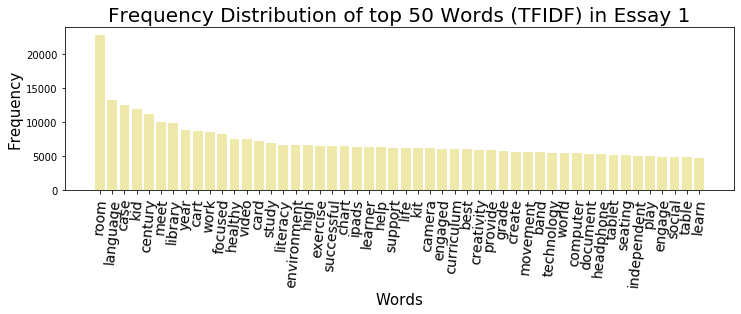

In [192]:
sum_words_tf = df_After_essay1.sum(axis=0)
words_freq_tf = [(word, sum_words_tf[0, idx]) for word, idx in tfidf.vocabulary_.items()]
words_freq_tf =sorted(words_freq_tf, key = lambda x: x[1], reverse=True) # list of tuples in order

words_frequency_tf=Convert(words_freq_tf)
top_50_tf=dict(Counter(words_frequency_tf).most_common(50))

plt.figure(figsize=(12,3))
plt.title('Frequency Distribution of top 50 Words (TFIDF) in Essay 1',size=20)
plt.ylabel('Frequency',size=15)
plt.xlabel('Words',size=15)
plt.xticks(rotation=85,size=14)
plt.bar(top_50_tf.keys(),top_50_tf.values(),color='palegoldenrod')
plt.gca().xaxis.grid(False)
plt.show()

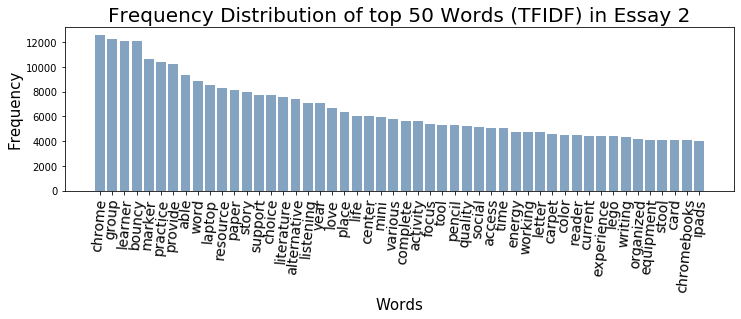

In [191]:
sum_words_tf = df_After_essay2.sum(axis=0)
words_freq_tf = [(word, sum_words_tf[0, idx]) for word, idx in tfidf.vocabulary_.items()]
words_freq_tf =sorted(words_freq_tf, key = lambda x: x[1], reverse=True) # list of tuples in order

words_frequency_tf=Convert(words_freq_tf)
top_50_tf=dict(Counter(words_frequency_tf).most_common(50))

plt.figure(figsize=(12,3))
plt.title('Frequency Distribution of top 50 Words (TFIDF) in Essay 2',size=20)
plt.ylabel('Frequency',size=15)
plt.xlabel('Words',size=15)
plt.xticks(rotation=85,size=14)
plt.bar(top_50_tf.keys(),top_50_tf.values(),color=(0.2, 0.4, 0.6, 0.6))
plt.gca().xaxis.grid(False)
plt.show()

In [ ]:
text_essay1= " ".join(five_rated['Cleaned_Comment'])

In [18]:
df_After = pd.read_csv('D:\df_After.csv')

invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d


In [312]:
essay1_text= " ".join(df_After['Cleaned_essay1'])

In [316]:
essay2_text= " ".join(df_After['Cleaned_essay2'])

In [313]:
#按模板填色
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
import imageio

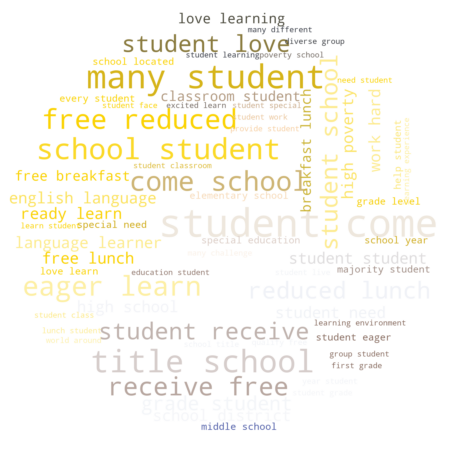

In [315]:
mk = imageio.imread("D:/student.png")
wc = WordCloud(max_font_size=20,max_words=1500,background_color="white",
               mask=mk, height=200,width=200,scale=8)
wc.generate(essay1_text)
image_colors = ImageColorGenerator(mk)
plt.figure(figsize=(12,8))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
# 给词云对象按模板图片的颜色重新上色
wc_color = wc.recolor(color_func=image_colors)
plt.axis('off')
plt.show()

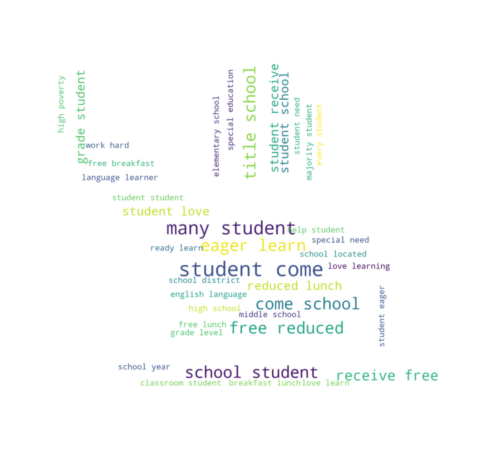

In [320]:
mk = imageio.imread("D:/studentnocolor.png")
wc = WordCloud(max_font_size=10,max_words=1500,background_color="white",
               mask=mk, height=200,width=200,scale=8)
wc.generate(essay1_text)
#image_colors = ImageColorGenerator(mk)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="gaussian")
#plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
# 给词云对象按模板图片的颜色重新上色
#wc_color = wc.recolor(color_func=image_colors)
plt.axis('off')
plt.show()

# 5. Xgboost Model for Prediction

In [29]:
df_After['prefix']=target_encode(trn_series=df_After['teacher_prefix'], 
                  #tst_series=None, 
                  target=df['approved'])
df_After['prefix'].head(10)

0    0.843052
1    0.854085
2    0.843052
3    0.842022
4    0.842022
5    0.854085
6    0.854085
7    0.854085
8    0.843052
9    0.854085
Name: prefix, dtype: float64

In [30]:
df_After=df_After.drop(['teacher_prefix','state','id'],axis=1)

In [31]:
df_After['total_cost']=df['total_cost']#from the beginning

In [32]:
Y=df_After['approved']

In [33]:
df_After=df_After.drop(['approved'],axis=1)

In [34]:
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
cols_to_normalize = ['previous_posted', 'total_quantity', 'mean_cost', 'total_cost',
                     'Unclean_len_subject', 'Unclean_len_title', 'Unclean_len_essay1', 'Unclean_len_essay2', 'Unclean_len_summary',
                     'essay_length']
scaler = StandardScaler()
for col in cols_to_normalize:
    #print(col)
    scaler.fit(df_After[col].values.reshape(-1, 1))
    df_After[col] = scaler.transform(df_After[col].values.reshape(-1, 1))


In [37]:
df_After.head(1)

,previous_posted,item_count,total_quantity,mean_cost,total_cost,school_state,Unclean_len_subject,Unclean_len_title,Unclean_len_essay1,Unclean_len_essay2,Unclean_len_summary,essay_length,prefix
0,1.357682,0.82845,-0.313174,0.453781,0.646102,0.85677,-0.749954,-0.775878,1.672146,-0.063101,0.076789,0.815361,0.843052


In [36]:
df_After=df_After.drop(['Cleaned_subject','Cleaned_subject_sub','Cleaned_title','Cleaned_essay1','Cleaned_essay2','Cleaned_summary'], axis=1)

In [42]:
import scipy.sparse
from scipy.sparse import csr_matrix

In [43]:
X = csr_matrix(scipy.sparse.hstack([df_After.values,df_After_subject, df_After_subject_sub, 
                                    df_After_summary, df_After_essay1, df_After_essay2]))

In [44]:
X

<182080x675 sparse matrix of type '<class 'numpy.float64'>'
	with 11773149 stored elements in Compressed Sparse Row format>

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [48]:
import xgboost as xgb

In [49]:
params = {'eta': 0.05, 'max_depth': 15, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 42, 'silent': True, 'colsample':0.9}
watchlist = [(xgb.DMatrix(x_train, y_train), 'train'), (xgb.DMatrix(x_test, y_test), 'test')]
model = xgb.train(params, xgb.DMatrix(x_train, y_train), 1000,  watchlist, verbose_eval=10, early_stopping_rounds=20)

[0]	train-auc:0.77521	test-auc:0.70013
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[10]	train-auc:0.87148	test-auc:0.71853
[20]	train-auc:0.90820	test-auc:0.72570
[30]	train-auc:0.93142	test-auc:0.73111
[40]	train-auc:0.94910	test-auc:0.73703
[50]	train-auc:0.96176	test-auc:0.74165
[60]	train-auc:0.97024	test-auc:0.74469
[70]	train-auc:0.97687	test-auc:0.74742
[80]	train-auc:0.98204	test-auc:0.74975
[90]	train-auc:0.98583	test-auc:0.75158
[100]	train-auc:0.98842	test-auc:0.75274
[110]	train-auc:0.99035	test-auc:0.75388
[120]	train-auc:0.99189	test-auc:0.75443
[130]	train-auc:0.99305	test-auc:0.75473
[140]	train-auc:0.99427	test-auc:0.75456
[150]	train-auc:0.99507	test-auc:0.75504
[160]	train-auc:0.99572	test-auc:0.75519
[170]	train-auc:0.99632	test-auc:0.75530
[180]	train-auc:0.99677	test-auc:0.75556
[190]	train-auc:0.99709	test-auc:0.75575
[200]	train-auc:0.99743	test-auc:0.75582
[210]	tra